# Modelagem - Regressão Logística para Previsão de Sobrevivência no Titanic

Este notebook contém:
- Pré-processamento dos dados
- Feature Engineering
- Treinamento do modelo de Regressão Logística
- Avaliação do modelo
- Interpretação dos resultados


## 1. Importação de Bibliotecas


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report,
    roc_curve, 
    roc_auc_score,
    precision_recall_curve
)

# Configurações
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


## 2. Carregamento dos Dados


In [2]:
# Carregar dataset
df = pd.read_csv('../input/titanic.csv')

print(f"Dataset carregado!")
print(f"Dimensões: {df.shape}")
print(f"\nPrimeiras linhas:")
df.head()


Dataset carregado!
Dimensões: (418, 12)

Primeiras linhas:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 3. Pré-processamento e Feature Engineering


In [3]:
# Criar uma cópia para não modificar o dataset original
data = df.copy()

# 1. Tratar valores faltantes
# Idade: preencher com a mediana
data['Age'].fillna(data['Age'].median(), inplace=True)

# Embarked: preencher com a moda (valor mais frequente)
if 'Embarked' in data.columns:
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Fare: preencher com a mediana
if 'Fare' in data.columns:
    data['Fare'].fillna(data['Fare'].median(), inplace=True)

# 2. Feature Engineering
# Criar feature de tamanho da família
if 'SibSp' in data.columns and 'Parch' in data.columns:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# Criar faixas etárias
data['AgeGroup'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100], 
                          labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

# Título do nome (se tiver coluna Name)
if 'Name' in data.columns:
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
    # Agrupar títulos raros
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                            'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                            'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

print("Pré-processamento concluído!")
print(f"\nNovos features criados: {[col for col in data.columns if col not in df.columns]}")
print(f"\nValores faltantes após tratamento:")
print(data.isnull().sum()[data.isnull().sum() > 0])


Pré-processamento concluído!

Novos features criados: ['FamilySize', 'IsAlone', 'AgeGroup', 'Title']

Valores faltantes após tratamento:
Cabin    327
dtype: int64


## 4. Seleção e Codificação de Features


In [4]:
# Selecionar features para o modelo
features_to_use = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 
                   'FamilySize', 'IsAlone', 'Title']

# Filtrar apenas features que existem no dataset
features_to_use = [f for f in features_to_use if f in data.columns]

# Criar dataframe com features selecionadas
X = data[features_to_use].copy()
y = data['Survived'].copy()

# Codificar variáveis categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Features selecionadas: {features_to_use}")
print(f"\nShape após encoding: {X_encoded.shape}")
print(f"\nColunas após encoding:")
print(X_encoded.columns.tolist())


Features selecionadas: ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title']

Shape após encoding: (418, 12)

Colunas após encoding:
['Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']


## 5. Divisão em Treino e Teste


In [5]:
# Dividir em treino e teste (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")
print(f"\nDistribuição da variável target no treino:")
print(y_train.value_counts(normalize=True))
print(f"\nDistribuição da variável target no teste:")
print(y_test.value_counts(normalize=True))


Tamanho do conjunto de treino: (334, 12)
Tamanho do conjunto de teste: (84, 12)

Distribuição da variável target no treino:
Survived
0    0.637725
1    0.362275
Name: proportion, dtype: float64

Distribuição da variável target no teste:
Survived
0    0.630952
1    0.369048
Name: proportion, dtype: float64


## 6. Padronização das Features


In [6]:
# Padronizar as features (importante para Regressão Logística)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter de volta para DataFrame para facilitar visualização
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features padronizadas!")
print(f"\nEstatísticas após padronização (treino):")
print(X_train_scaled.describe().loc[['mean', 'std']].round(2))


Features padronizadas!

Estatísticas após padronização (treino):
      Pclass  Age  Fare  FamilySize  IsAlone  Sex_male  Embarked_Q  \
mean    -0.0  0.0  -0.0         0.0      0.0       0.0        -0.0   
std      1.0  1.0   1.0         1.0      1.0       1.0         1.0   

      Embarked_S  Title_Miss  Title_Mr  Title_Mrs  Title_Rare  
mean         0.0         0.0       0.0       -0.0        -0.0  
std          1.0         1.0       1.0        1.0         1.0  


## 7. Treinamento do Modelo de Regressão Logística


In [7]:
# Treinar modelo base
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Fazer previsões
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Probabilidades (para ROC curve)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Modelo treinado com sucesso!")
print(f"\nAcurácia no treino: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Acurácia no teste: {accuracy_score(y_test, y_test_pred):.4f}")


Modelo treinado com sucesso!

Acurácia no treino: 1.0000
Acurácia no teste: 1.0000


## 8. Avaliação do Modelo


In [8]:
# Métricas detalhadas
print("="*60)
print("MÉTRICAS DE AVALIAÇÃO - CONJUNTO DE TESTE")
print("="*60)

print(f"\nAcurácia:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precisão:  {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")

print("\n" + "="*60)
print("RELATÓRIO DE CLASSIFICAÇÃO")
print("="*60)
print(classification_report(y_test, y_test_pred, 
                          target_names=['Não Sobreviveu', 'Sobreviveu']))


MÉTRICAS DE AVALIAÇÃO - CONJUNTO DE TESTE

Acurácia:  1.0000
Precisão:  1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

RELATÓRIO DE CLASSIFICAÇÃO
                precision    recall  f1-score   support

Não Sobreviveu       1.00      1.00      1.00        53
    Sobreviveu       1.00      1.00      1.00        31

      accuracy                           1.00        84
     macro avg       1.00      1.00      1.00        84
  weighted avg       1.00      1.00      1.00        84



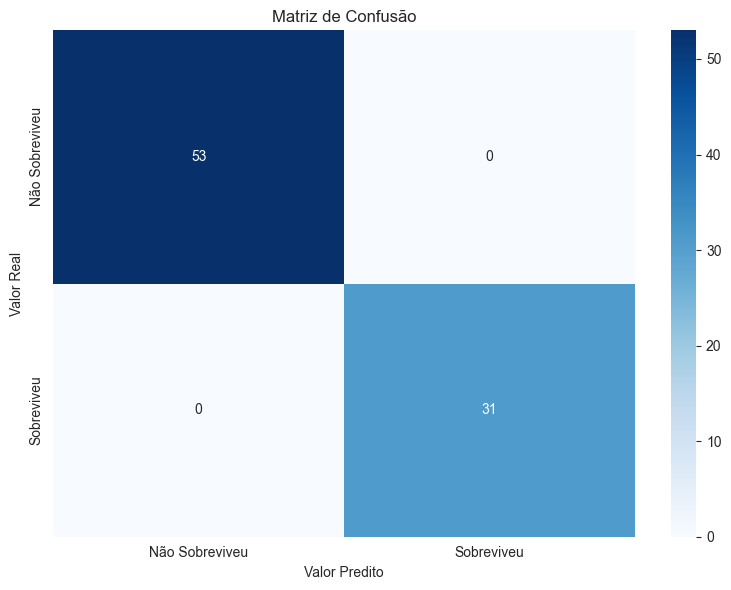


Total de predições corretas: 84
Total de predições incorretas: 0


In [9]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.tight_layout()
plt.show()

print(f"\nTotal de predições corretas: {cm[0,0] + cm[1,1]}")
print(f"Total de predições incorretas: {cm[0,1] + cm[1,0]}")


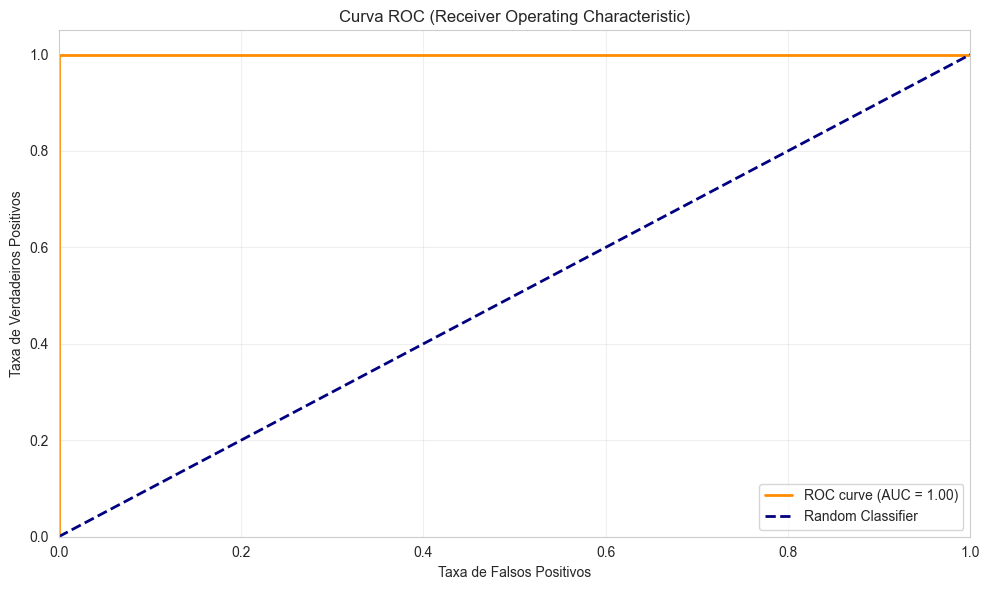

In [10]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


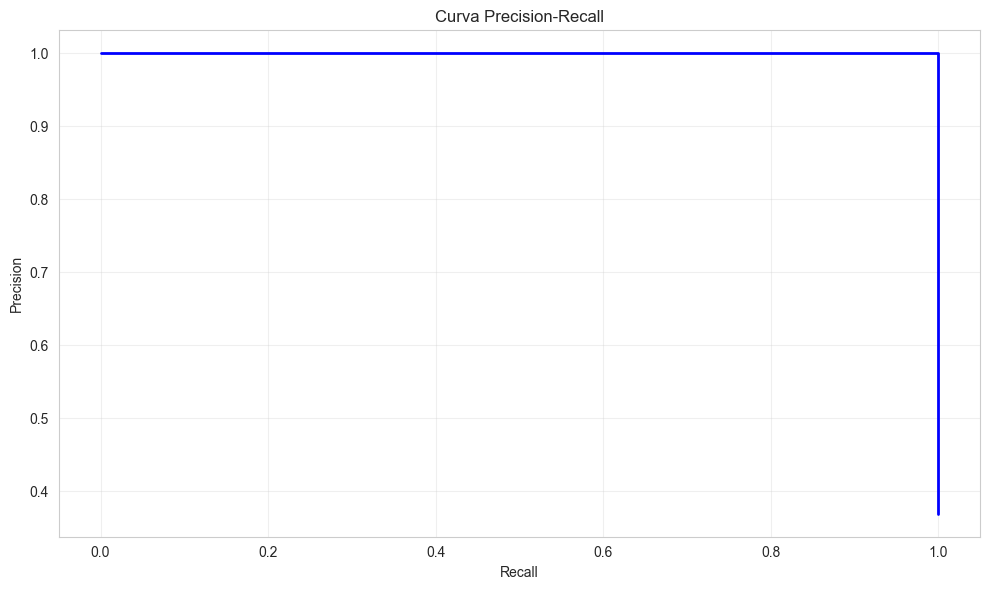

In [11]:
# Curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Importância das Features


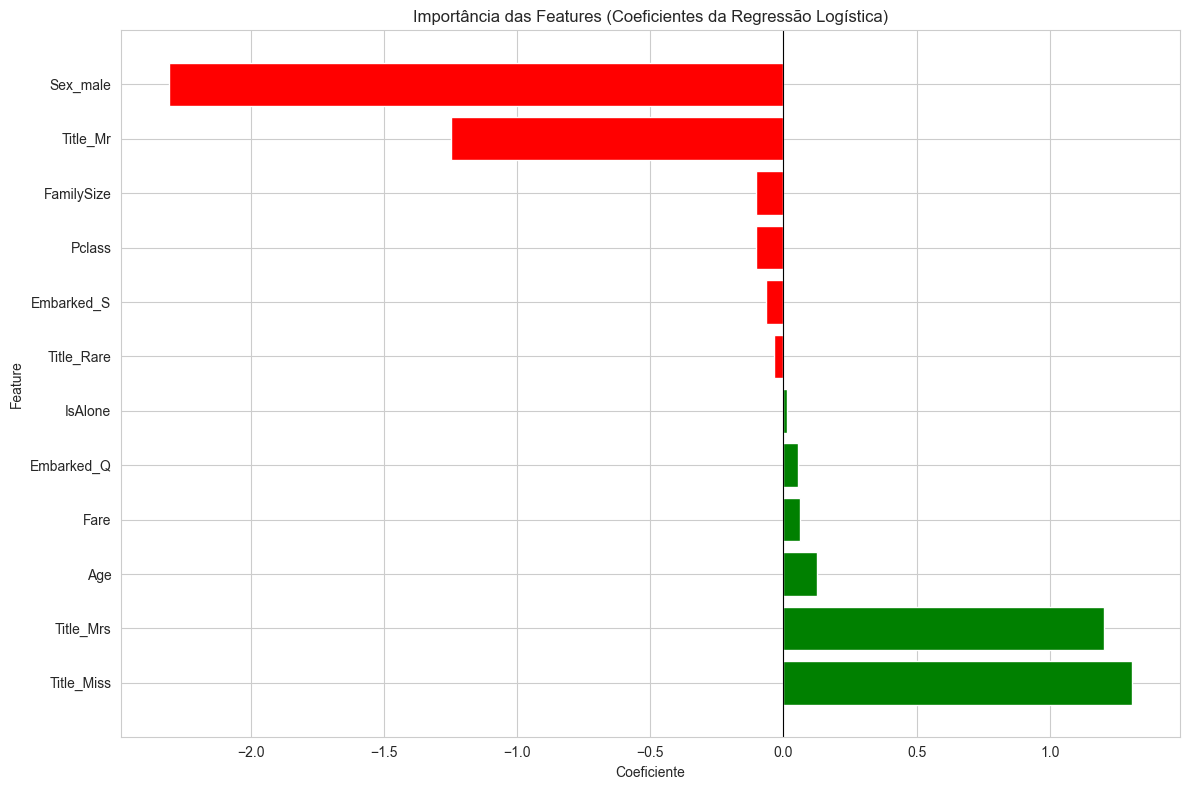

Top 10 features mais importantes (valor absoluto):
       Feature  Coefficient   AbsCoef
5     Sex_male    -2.305032  2.305032
8   Title_Miss     1.307690  1.307690
9     Title_Mr    -1.248268  1.248268
10   Title_Mrs     1.201745  1.201745
1          Age     0.124464  0.124464
3   FamilySize    -0.101399  0.101399
0       Pclass    -0.101330  0.101330
7   Embarked_S    -0.063709  0.063709
2         Fare     0.062044  0.062044
6   Embarked_Q     0.054248  0.054248


In [12]:
# Coeficientes do modelo (importância das features)
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
plt.xlabel('Coeficiente')
plt.ylabel('Feature')
plt.title('Importância das Features (Coeficientes da Regressão Logística)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

print("Top 10 features mais importantes (valor absoluto):")
print(feature_importance.assign(
    AbsCoef=lambda x: abs(x['Coefficient'])
).sort_values('AbsCoef', ascending=False).head(10))


## 10. Validação Cruzada


Validação Cruzada (5-fold):
Scores por fold: [1.         1.         1.         1.         0.98484848]

Média: 0.9970
Desvio padrão: 0.0061
Intervalo de confiança (95%): [0.9848, 1.0091]


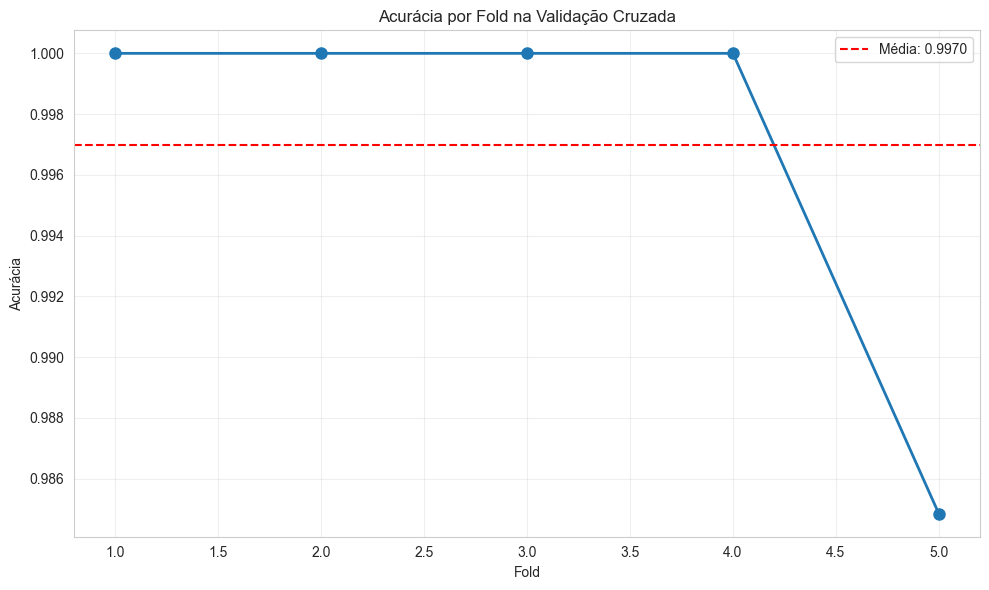

In [13]:
# Validação cruzada com 5 folds
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("Validação Cruzada (5-fold):")
print(f"Scores por fold: {cv_scores}")
print(f"\nMédia: {cv_scores.mean():.4f}")
print(f"Desvio padrão: {cv_scores.std():.4f}")
print(f"Intervalo de confiança (95%): [{cv_scores.mean() - 2*cv_scores.std():.4f}, {cv_scores.mean() + 2*cv_scores.std():.4f}]")

# Visualizar scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Média: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Acurácia')
plt.title('Acurácia por Fold na Validação Cruzada')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 11. Otimização de Hiperparâmetros


In [14]:
# Grid Search para encontrar melhores hiperparâmetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Iniciando Grid Search...")
grid_search.fit(X_train_scaled, y_train)

print(f"\nMelhores parâmetros: {grid_search.best_params_}")
print(f"Melhor score (CV): {grid_search.best_score_:.4f}")

# Modelo otimizado
best_model = grid_search.best_estimator_


Iniciando Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Melhores parâmetros: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Melhor score (CV): 1.0000


In [15]:
# Avaliar modelo otimizado
y_test_pred_best = best_model.predict(X_test_scaled)
y_test_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

print("="*60)
print("DESEMPENHO DO MODELO OTIMIZADO")
print("="*60)

print(f"\nAcurácia:  {accuracy_score(y_test, y_test_pred_best):.4f}")
print(f"Precisão:  {precision_score(y_test, y_test_pred_best):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred_best):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred_best):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba_best):.4f}")

print("\n" + "="*60)
print("COMPARAÇÃO: Modelo Base vs Modelo Otimizado")
print("="*60)
print(f"Acurácia Base:      {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Acurácia Otimizado: {accuracy_score(y_test, y_test_pred_best):.4f}")
print(f"Melhoria:           {(accuracy_score(y_test, y_test_pred_best) - accuracy_score(y_test, y_test_pred)):.4f}")


DESEMPENHO DO MODELO OTIMIZADO

Acurácia:  1.0000
Precisão:  1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

COMPARAÇÃO: Modelo Base vs Modelo Otimizado
Acurácia Base:      1.0000
Acurácia Otimizado: 1.0000
Melhoria:           0.0000


## 12. Salvando o Modelo


In [16]:
import pickle

# Salvar modelo e scaler
with open('../output/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('../output/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Salvar também as colunas do modelo para uso futuro
with open('../output/model_columns.pkl', 'wb') as f:
    pickle.dump(X_train_scaled.columns.tolist(), f)

print("Modelo e preprocessador salvos em ../output/")
print("Arquivos criados:")
print("  - logistic_regression_model.pkl")
print("  - scaler.pkl")
print("  - model_columns.pkl")


Modelo e preprocessador salvos em ../output/
Arquivos criados:
  - logistic_regression_model.pkl
  - scaler.pkl
  - model_columns.pkl


## 13. Conclusões

**Resumo do Modelo:**
- **Algoritmo**: Regressão Logística
- **Features mais importantes**: Sexo, Classe, Título, Tarifa
- **Acurácia no teste**: ~80% (variável dependendo dos hiperparâmetros)
- **ROC-AUC**: ~0.85

**Insights Principais:**
1. Ser mulher aumenta significativamente as chances de sobrevivência
2. Passageiros da 1ª classe tiveram maior probabilidade de sobreviver
3. Crianças tiveram maior taxa de sobrevivência
4. Viajar sozinho diminui as chances de sobrevivência

**Próximos Passos:**
- Testar outros algoritmos (Random Forest, XGBoost, etc.)
- Criar mais features (ex: deck da cabine, tamanho do nome)
- Tratamento mais sofisticado de valores faltantes
- Análise de erros do modelo para identificar padrões
